In [38]:
# -*- coding: utf-8 -*-
"""
MODELO HIDROLÓGICO TETIS AGREGADO - QUEBRADA EL CEMENTERIO
Basado en la conceptualización de Vélez et al. (UNAL Antioquia).
Enfoque "TETIS-like" en versión agregada (lumped), con separación clara de:
- tanque estático/capilar (S2) con capacidad FC,
- tanque superficial (S1) que recibe el excedente del estático,
- infiltración por CAPACIDAD diaria (S1->S3),
- percolación por CAPACIDAD diaria (S3->S4),
- interflow y baseflow como depósitos lineales,
- canal como depósito (lineal por defecto).

Cambio solicitado:
- La FUNCIÓN OBJETIVO minimiza RMSE calculado DESPUÉS de remover un período
  de calentamiento (WARMUP) de 6 meses mediante localización por posición
  (slicing posicional) en Qobs y Qsim. Ese warmup NO se usa en ninguna otra
  parte del código.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# =============================
#   CONFIGURACIÓN GLOBAL
# =============================

# Warmup de 6 meses (≈ 182 días) para el cálculo de RMSE EN LA FUNCIÓN OBJETIVO
WARMUP_DAYS = 182

# =============================
#   MÉTRICAS
# =============================

def nash_sutcliffe_efficiency(observed, simulated):
    observed = np.asarray(observed, dtype=float)
    simulated = np.asarray(simulated, dtype=float)
    valid = ~(np.isnan(observed) | np.isnan(simulated) | np.isinf(observed) | np.isinf(simulated))
    if np.sum(valid) < 2:
        return np.nan
    obs = observed[valid]
    sim = simulated[valid]
    den = np.sum((obs - np.mean(obs))**2)
    if den == 0:
        return np.nan
    return 1.0 - (np.sum((obs - sim)**2) / den)

def rmse_metric(observed, simulated):
    observed = np.asarray(observed, dtype=float)
    simulated = np.asarray(simulated, dtype=float)
    valid = ~(np.isnan(observed) | np.isnan(simulated) | np.isinf(observed) | np.isinf(simulated))
    if np.sum(valid) == 0:
        return np.nan
    obs = observed[valid]
    sim = simulated[valid]
    return np.sqrt(np.mean((obs - sim)**2))

def mae_metric(observed, simulated):
    observed = np.asarray(observed, dtype=float)
    simulated = np.asarray(simulated, dtype=float)
    valid = ~(np.isnan(observed) | np.isnan(simulated) | np.isinf(observed) | np.isinf(simulated))
    if np.sum(valid) == 0:
        return np.nan
    obs = observed[valid]
    sim = simulated[valid]
    return np.mean(np.abs(obs - sim))

def pbias_metric(observed, simulated):
    observed = np.asarray(observed, dtype=float)
    simulated = np.asarray(simulated, dtype=float)
    valid = ~(np.isnan(observed) | np.isnan(simulated) | np.isinf(observed) | np.isinf(simulated))
    if np.sum(valid) == 0:
        return np.nan
    obs = observed[valid]
    sim = simulated[valid]
    if np.sum(obs) == 0:
        return np.nan
    return 100.0 * np.sum(sim - obs) / np.sum(obs)

def r2_metric(observed, simulated):
    observed = np.asarray(observed, dtype=float)
    simulated = np.asarray(simulated, dtype=float)
    valid = ~(np.isnan(observed) | np.isnan(simulated) | np.isinf(observed) | np.isinf(simulated))
    if np.sum(valid) < 2:
        return np.nan
    obs = observed[valid]
    sim = simulated[valid]
    r = np.corrcoef(obs, sim)[0, 1]
    return r**2

def kge_metric(observed, simulated):
    observed = np.asarray(observed, dtype=float)
    simulated = np.asarray(simulated, dtype=float)
    valid = ~(np.isnan(observed) | np.isnan(simulated) | np.isinf(observed) | np.isinf(simulated))
    if np.sum(valid) < 2:
        return np.nan
    obs = observed[valid]
    sim = simulated[valid]
    r = np.corrcoef(obs, sim)[0, 1]
    alpha = np.std(sim) / (np.std(obs) + 1e-12)
    beta = np.mean(sim) / (np.mean(obs) + 1e-12)
    return 1.0 - np.sqrt((r - 1.0)**2 + (alpha - 1.0)**2 + (beta - 1.0)**2)

# ==========================================
#   OPTIMIZACIÓN: EVOLUCIÓN DIFERENCIAL (DE)
# ==========================================

def differential_evolution(func, bounds, args=(), maxiter=200, popsize=15, seed=None):
    """
    Implementación simple de Evolución Diferencial para minimizar func(x, *args).
    """
    if seed is not None:
        np.random.seed(seed)

    n_params = len(bounds)
    population = np.zeros((popsize, n_params), dtype=float)

    # Población inicial
    for j, (low, high) in enumerate(bounds):
        population[:, j] = np.random.uniform(low, high, size=popsize)

    # Evaluación inicial
    fitness = np.empty(popsize, dtype=float)
    for i in range(popsize):
        try:
            fitness[i] = func(population[i], *args)
        except Exception:
            fitness[i] = np.inf

    best_idx = int(np.argmin(fitness))
    best_params = population[best_idx].copy()
    best_f = float(fitness[best_idx])

    # Parámetros DE
    F = np.random.uniform(0.5, 1.0)
    CR = 0.7

    for _ in range(maxiter):
        for i in range(popsize):
            # Mutación: seleccionar a, b, c != i
            idxs = [idx for idx in range(popsize) if idx != i]
            a, b, c = np.random.choice(idxs, 3, replace=False)
            mutant = population[a] + F * (population[b] - population[c])

            # Restringir por límites
            for j in range(n_params):
                low, high = bounds[j]
                if mutant[j] < low:
                    mutant[j] = low + np.random.random() * (high - low) * 0.1
                elif mutant[j] > high:
                    mutant[j] = high - np.random.random() * (high - low) * 0.1

            # Cruce
            trial = population[i].copy()
            j_rand = np.random.randint(n_params)
            for j in range(n_params):
                if np.random.random() < CR or j == j_rand:
                    trial[j] = mutant[j]

            # Selección
            try:
                f_trial = func(trial, *args)
            except Exception:
                f_trial = np.inf

            if f_trial < fitness[i]:
                population[i] = trial
                fitness[i] = f_trial
                if f_trial < best_f:
                    best_f = f_trial
                    best_params = trial.copy()

    class OptimizeResult:
        def __init__(self, x, fun, success=True, message="Optimization terminated successfully"):
            self.x = x
            self.fun = fun
            self.success = success
            self.message = message

    return OptimizeResult(best_params, best_f, True)

# ==========================================
#   UTILIDAD: CARGA Y PREPROCESO DE DATOS
# ==========================================

def load_and_preprocess_data(csv_path):
    """
    Se espera un CSV con columnas: date, P_mm, PET_mm, Qobs_m3s
    - date en formato YYYY/MM/DD o ISO.
    """
    df = pd.read_csv(csv_path)

    rename_map = {
        "Fecha": "date",
        "PVer_mm": "P_mm",
        "Q5_m3s": "Qobs_m3s",
        "ETP_mm": "PET_mm"
    }

    df = df.rename(columns=rename_map)

    print(df.head())
    if 'date' not in df.columns:
        raise ValueError("El CSV debe contener la columna 'date'.")
    df['date'] = pd.to_datetime(df['date'])

    for col in ('P_mm', 'PET_mm'):
        if col not in df.columns:
            raise ValueError(f"Falta la columna obligatoria '{col}'.")
        df[col] = df[col].fillna(0.0).astype(float)

    if 'Qobs_m3s' not in df.columns:
        # Permitir trabajar sin Qobs (p.ej., sólo simulación)
        df['Qobs_m3s'] = np.nan
    else:
        df['Qobs_m3s'] = pd.to_numeric(df['Qobs_m3s'], errors='coerce')

    return df

# ==========================================
#   MODELO TETIS AGREGADO (RUN TETIS-LIKE)
# ==========================================

class TetisAggregatedModel:
    """
    Modelo TETIS-like, conservando los nombres originales de parámetros:
      I_max, S1_max, FC, k1, n, k2, k3, k4, k5, k_gw, k_inf

    Estados (mm):
      I (intercepción), S2 (estático/capilar, cap=FC), S1 (superficial),
      S3 (gravitacional), S4 (acuífero), S5 (canal).
    """

    def __init__(self, area_m2):
        self.area = float(area_m2)  # m²
        # Rangos razonables (ajustables a cada cuenca)
        self.param_bounds = [
            (0.1, 5.0),     # I_max [mm]
            (1.0, 80.0),    # S1_max [mm] (se usa solo para escalar I2_cap)
            (50.0, 500.0),  # FC [mm]
            (0.1, 1.2),     # k1 [-] fracción PET efectiva
            (1.0, 10.0),    # n [-] exponente interflow
            (0.001, 1.0),   # k2 [d^-1] -> I2s_cap = k2*FC
            (0.001, 1.0),   # k3 [d^-1] coef. interflow
            (0.001, 0.2),   # k4 [d^-1] coef. baseflow
            (0.05, 15.0),   # k5 [d^-1] vaciado de canal
            (0.001, 1.5),   # k_gw [d^-1] -> I3_cap = k_gw*FC
            (0.001, 2.0)    # k_inf [d^-1] -> I2_cap = k_inf*S1_max
        ]

    def run(self, precip, etp, params):
        """
        Simulación diaria. NO usa warmup aquí.
        precip, etp: arrays [mm/d]
        params: [I_max, S1_max, FC, k1, n, k2, k3, k4, k5, k_gw, k_inf]
        """
        precip = np.asarray(precip, dtype=float)
        etp = np.asarray(etp, dtype=float)
        n_days = len(precip)
        if len(etp) != n_days:
            raise ValueError("precip y etp deben tener igual longitud.")

        I_max, S1_max, FC, k1, n, k2, k3, k4, k5, k_gw, k_inf = [float(x) for x in params]

        # Estados iniciales
        I = 0.0
        S1 = 0.0
        S2 = 0.5 * FC
        S3 = 0.0
        S4 = 10.0
        S5 = 0.0

        # Capacidades (mm/d)
        I2_cap  = max(0.0, k_inf * S1_max)  # S1 -> S3
        I3_cap  = max(0.0, k_gw  * FC)      # S3 -> S4
        I2s_cap = max(0.0, k2    * FC)      # S2 -> S3 (drenaje continuo)

        discharge = np.zeros(n_days, dtype=float)
        
        for t in range(n_days):
            P = precip[t]
            PET = etp[t]
            
            # # 1. INTERCEPCIÓN
            # # La lluvia primero llena la intercepción
            # if P > 0:
            #     P_net = max(0, P + I - I_max)
            #     I = min(I_max, I + P)
            # else:
            #     P_net = 0

            # # Evaporación desde intercepción
            # E_I = min(I, PET)
            # I = max(0, I - E_I)
            # PET_remaining = max(0, PET - E_I)
            
            # 1. INTERCEPCIÓN (I) y throughfall
            # capacidad remanente del dosel
            cap_rem = max(0.0, I_max - I)
            # lluvia que cae al dosel hasta llenar
            retained = min(P, cap_rem)
            I = I + retained
            # throughfall (P neta)
            P_net = max(0.0, P - retained)  # Asegura no negativo

            # evaporación desde intercepción
            E_I = min(I, PET)
            I = max(0.0, I - E_I)
            PET_remaining = max(0.0, PET - E_I)


            
            # # 2. ALMACENAMIENTO SUPERFICIAL (S1)
            # # Entrada al almacenamiento superficial
            # S1 += P_net

            # # Evaporación desde S1
            # E_S1 = min(S1, PET_remaining * 0.1)  # Factor reducido para S1
            # S1 = max(0, S1 - E_S1)
            # PET_remaining = max(0, PET_remaining - E_S1)
            
            # # Exceso que pasa al suelo
            # if S1 > S1_max:
            #     excess_to_soil = S1 - S1_max
            #     S1 = S1_max
            # else:
            #     excess_to_soil = S1 * 0.1  # Infiltración gradual
            #     S1 = S1 * 0.9

            # 2. ALMACENAMIENTO SUPERFICIAL (S1)
            S1 += P_net

            # Evaporación limitada desde S1 (pequeña fracción)
            E_S1 = min(S1, 0.1 * PET_remaining)
            S1 = max(0.0, S1 - E_S1)
            PET_remaining = max(0.0, PET_remaining - E_S1)

            # # Infiltración desde S1 hacia S2 con tasa k_inf
            # # Flujo (mm/d) = k_inf * S1 * (1 + S1/S1_max)  (capado por S1)
            # infil = k_inf * S1 * (1.0 + S1 / (S1_max + 1e-6))
            # infil = min(infil, S1)
            # S1 -= infil
            # excess_to_soil = infil

            # # Exceso por capacidad superficial (escorrentía rápida a canal opcional)
            # if S1 > S1_max:
            #     overland = S1 - S1_max
            #     S1 = S1_max
            # else:
            #     overland = 0.0

            # # 3. HUMEDAD DEL SUELO (S2)
            # S2 += excess_to_soil

            # Infiltración desde S1 hacia S2 con tasa k_inf
            if S1 > S1_max:
                excess = S1 - S1_max
                S1 = S1_max
                infil = min(excess * 0.8, excess)  # 80% infiltra, resto overland (ajustable)
                overland = excess - infil
            else:
                infil = k_inf * S1  # Tasa lineal cuando no saturado
                overland = 0.0
                S1 = max(0.0, S1 - infil)
            
            # 3. HUMEDAD DEL SUELO (S2)
            S2 += infil

            # Evapotranspiración real desde el suelo
            if S2 > 0:
                ET_factor = min(1.0, S2 / (FC))  # Factor de estrés hídrico
                ETR = min(S2, PET_remaining * k1 * ET_factor)
                S2 = max(0.0, S2 - ETR)
            else:
                ETR = 0.0
            
            # Percolación hacia zona no saturada (S3)
            if S2 > FC:
                percolation = k2 * (S2 - FC)
                S2 = max(0.0, S2 - percolation)
            else:
                percolation = 0.0

            S2 = max(0, S2 - percolation)

            # # 4. ZONA NO SATURADA (S3)
            # S3 = S3 + percolation
            
            # # Flujo subsuperficial (interflow)
            # if S3 > 0:
            #     interflow = k3 * (S3 ** n)
            #     S3 = max(0, S3 - interflow)
            # else:
            #     interflow = 0
                
            # # Recarga al acuífero
            # groundwater_recharge = k2 * 0.5 * S3
            # S3 = max(0, S3 - groundwater_recharge)
            
            # # 5. ACUÍFERO (S4)
            # S4 = S4 + groundwater_recharge
            
            # # Flujo base
            # baseflow = k4 * S4
            # S4 = max(0, S4 - baseflow)

            # 4. ZONA NO SATURADA (S3)
            S3 += percolation

            # Flujo subsuperficial (no lineal, adimensional en base)
            interflow = k3 * S3 * (S3 / (FC + 1e-6))**(n - 1.0)  # mantiene unidades de k3 como d^-1
            interflow = min(interflow, S3)
            S3 = max(0.0, S3 - interflow)

            # Recarga al acuífero separada
            groundwater_recharge = k_gw * S3
            groundwater_recharge = min(groundwater_recharge, S3)
            S3 = max(0.0, S3 - groundwater_recharge)

            # 5. ACUÍFERO (S4)
            S4 += groundwater_recharge
            baseflow = k4 * S4
            baseflow = min(baseflow, S4)
            S4 = max(0.0, S4 - baseflow)
            
            # 6. CANAL (S5)
            # Entrada al canal: interflow + baseflow + escorrentía superficial
            channel_inflow = interflow + baseflow + overland
            S5 += channel_inflow

            # Flujo de salida del canal
            channel_outflow = k5 * S5 
            # S5 = max(0, S5 - channel_outflow)
            channel_outflow = min(channel_outflow, S5)
            S5 = max(0.0, S5 - channel_outflow)
            
            # Conversión a caudal [m³/s]
            # channel_outflow está en mm/día, convertir a m³/s
            discharge[t] = (channel_outflow / 1000.0) * self.area / 86400.0
        
        return discharge

    # ==========================================
    #   FUNCIÓN OBJETIVO: RMSE POST-WARMUP
    # ==========================================
    def objective_function(self, params, precip, etp, qobs):
        """
        Minimiza el RMSE entre Qsim y Qobs DESPUÉS de remover WARMUP_DAYS
        usando slicing POSICIONAL en ambos arreglos. No se usa warmup en run().
        """
        qsim = self.run(precip, etp, params)

        # Slicing posicional para remover warmup (6 meses ~ 182 días)
        start = min(WARMUP_DAYS, len(qsim))  # si la serie es más corta, no corta de más
        qs = qsim[start:]
        qo = np.asarray(qobs, dtype=float)[start:]

        # RMSE robusto a NaNs
        valid = ~(np.isnan(qs) | np.isnan(qo) | np.isinf(qs) | np.isinf(qo))
        if np.sum(valid) == 0:
            return np.inf
        return np.sqrt(np.mean((qo[valid] - qs[valid])**2))

    # ==========================================
    #   CALIBRACIÓN
    # ==========================================
    def calibrate(self, precip, etp, qobs, maxiter=200, popsize=15, seed=42):
        """
        Calibra minimizando la objective_function (RMSE post-warmup).
        """
        result = differential_evolution(
            self.objective_function,
            self.param_bounds,
            args=(precip, etp, qobs),
            maxiter=maxiter,
            popsize=popsize,
            seed=seed
        )
        return result

# ==========================================
#   EVALUACIÓN Y GRÁFICOS
# ==========================================

def evaluate_model(qobs, qsim):
    valid = ~(np.isnan(qobs) | np.isnan(qsim) | np.isinf(qobs) | np.isinf(qsim))
    obs = np.asarray(qobs, dtype=float)[valid]
    sim = np.asarray(qsim, dtype=float)[valid]
    return {
        "NSE": nash_sutcliffe_efficiency(obs, sim),
        "RMSE": rmse_metric(obs, sim),
        "MAE": mae_metric(obs, sim),
        "PBIAS": pbias_metric(obs, sim),
        "R2": r2_metric(obs, sim),
        "KGE": kge_metric(obs, sim),
        "n": len(obs)
    }

def plot_results(dates, qobs, qsim, precip=None, etp=None, title_suffix=""):
    """
    Correcciones solicitadas:
    - Forzantes e Hidrograma comparten eje-x y sólo muestran el rango de 'dates' entregado.
    - La precipitación se grafica con 'plot' (no barras).
    - La Dispersión 1:1 va en una FIGURA SEPARADA (sin compartir ejes).
    """
    # Asegurar tipo datetime64 y rango de fechas sin huecos fuera del segmento
    dates = pd.to_datetime(dates)
    x0, x1 = dates.min(), dates.max()

    # -------- Figura 1: Forzantes + Hidrograma (2 filas, sharex=True) --------
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Forzantes (P y PET como línea)
    if precip is not None:
        axes[0].plot(dates, np.asarray(precip, dtype=float), label='P [mm/día]', lw=1.0)
    if etp is not None:
        axes[0].plot(dates, np.asarray(etp, dtype=float), label='PET [mm/día]', lw=1.0)
    axes[0].invert_yaxis()
    axes[0].set_title('Forzantes')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Hidrograma
    axes[1].plot(dates, np.asarray(qobs, dtype=float), 'b-', label='Observado', lw=1.5)
    axes[1].plot(dates, np.asarray(qsim, dtype=float), 'r--', label='Simulado', lw=1.2)
    axes[1].set_ylabel('Q [m³/s]')
    axes[1].set_title(f'Hidrograma {title_suffix}')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    # Limitar eje x exactamente al rango del segmento pasado
    axes[1].set_xlim(x0, x1)

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

    # -------- Figura 2: Dispersión 1:1 (separada, sin compartir ejes) --------
    plt.figure(figsize=(6, 6))
    qobs_arr = np.asarray(qobs, dtype=float)
    qsim_arr = np.asarray(qsim, dtype=float)
    mn = np.nanmin([qobs_arr, qsim_arr])
    mx = np.nanmax([qobs_arr, qsim_arr])
    plt.scatter(qobs_arr, qsim_arr, s=15, alpha=0.6)
    plt.plot([mn, mx], [mn, mx], 'k--', lw=1)
    plt.xlabel('Qobs [m³/s]')
    plt.ylabel('Qsim [m³/s]')
    plt.title('Dispersión 1:1')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()



In [39]:
# ==========================================
#   EJEMPLO DE USO (EDITA RUTA Y ÁREA)
# ==========================================

if __name__ == "__main__":
    # --- Ajusta esta ruta a tu CSV ---
    # --- Parámetros específicos para esta corrida ---
    DATA_DIR = Path(r"D:\OneDrive - Grupo EPM\Documentos\Python Scripts\Analisis_hidrologico_vertimientos\series_calibracion_Sigacal_2000-2022")
    
    estaciones = {
    "donamaria": {
        "Cuenca": "Q. Doña María",
        "SHAPE_Area": 17156557.78,
    },
    "elviento": {
        "Cuenca": "Q. El Viento",
        "SHAPE_Area": 4090254.774,
    },
    "laiguana": {
        "Cuenca": "Q. La Iguaná",
        "SHAPE_Area": 10112344.29,
    },
    "lalarga": {
        "Cuenca": "Q. La Larga",   # [No verificado] no aparece en la tabla original
        "SHAPE_Area": None,
    },
    "lalopez": {
        "Cuenca": "Q. La López",
        "SHAPE_Area": 2131957.74,
    },
    "lamanguala": {
        "Cuenca": "Q. La Manguala",
        "SHAPE_Area": 1838645.422,
    },
    "lapicacha": {
        "Cuenca": "Q. La Picacha",
        "SHAPE_Area": 2172068.811,
    },
    "lapuerta": {
        "Cuenca": "Q. La Puerta",
        "SHAPE_Area": 3849210.872,
    },
    "lareventona": {
        "Cuenca": "Q. La Reventona",
        "SHAPE_Area": 1347712.007,
    },
    "lasdespensas": {
        "Cuenca": "Q. Las Despensas",
        "SHAPE_Area": 1147785.21,
    },
    "lavaleria": {
        "Cuenca": "Q. La Valeria",
        "SHAPE_Area": 8721092.122,
    },
    "ovejas": {
        "Cuenca": "Q. Ovejas",
        "SHAPE_Area": 101011233.8,
    },
    "santaelena": {
        "Cuenca": "Q. Santa Elena",
        "SHAPE_Area": 11146635.58,
    },
    "piedrasblancas_embalse": {
        "Cuenca": "Q. Piedras Blancas",
        "SHAPE_Area": 24808470.51,
    },
}

    STATION = "lasdespensas"  # por ahora solo las despensas
    CSV_PATH = DATA_DIR / f"{STATION}_series.csv"

    # Área de la cuenca [m²] (ej.: 101 km² = 101e6 m²)
    area_cuenca = estaciones[STATION]["SHAPE_Area"]

    # 1) Cargar datos
    df = load_and_preprocess_data(CSV_PATH)
    # Renombrar a los nombres esperados por el modelo

    df = df.sort_values('date').reset_index(drop=True)

    # 2) Dividir en entrenamiento (70%) y validación (30%)
    split_idx = int(0.7 * len(df))
    train_df = df.iloc[:split_idx].copy()
    val_df   = df.iloc[split_idx:].copy()

    # 3) Crear modelo
    model = TetisAggregatedModel(area_m2=area_cuenca)

    # 4) Calibrar (usa RMSE post-warmup)
    precip_train = train_df['P_mm'].values
    etp_train    = train_df['PET_mm'].values
    qobs_train   = train_df['Qobs_m3s'].values
    result = model.calibrate(precip_train, etp_train, qobs_train, maxiter=120, popsize=20, seed=42)

    print("\n== RESULTADO DE CALIBRACIÓN ==")
    print("Éxito:", result.success)
    print("Mensaje:", result.message)
    print("RMSE post-warmup (objetivo) =", result.fun)
    param_names = ['I_max','S1_max','FC','k1','n','k2','k3','k4','k5','k_gw','k_inf']
    for nme, val in zip(param_names, result.x):
        print(f"{nme:8s}: {val:.4f}")

    # 5) Simular validación con los mejores parámetros
    precip_val = val_df['P_mm'].values
    etp_val    = val_df['PET_mm'].values
    qobs_val   = val_df['Qobs_m3s'].values
    qsim_val   = model.run(precip_val, etp_val, result.x)

    # 6) Evaluar en validación (sin warmup aquí)
    metrics = evaluate_model(qobs_val, qsim_val)
    print("\n== MÉTRICAS VALIDACIÓN (sin warmup) ==")
    for k, v in metrics.items():
        print(f"{k:6s}: {v:.4f}" if isinstance(v, float) else f"{k:6s}: {v}")


         date     TA(oC)  TAmin(oC)  TAmax(oC)  HR(kPa.kPa-1)  RS(MJ.m-2.d-1)  \
0  2000-01-01  18.409357  11.423229  25.395484       0.877947       19.465600   
1  2000-01-02  17.239831   9.957260  24.522401       0.903472       15.652516   
2  2000-01-03  17.906576  11.585826  24.227326       0.879187       14.745015   
3  2000-01-04  17.717157  11.811968  23.622346       0.925650       16.186272   
4  2000-01-05  17.199632  11.429040  22.970223       0.926116       14.169050   

    PVer(m)     U(m.d-1)    Ux(m.d-1)     Uy(m.d-1)    ETo(m)    ETP(m)  \
0  0.000017  243449.4572  123306.7105  209912.10870  0.003277  0.003869   
1  0.000085  166520.1704  144776.1411   82272.93674  0.002682  0.003084   
2  0.000097  208709.6957  200262.4737  -58776.51471  0.002645  0.003082   
3  0.007727  156122.6572  108176.0465 -112570.98680  0.002736  0.003118   
4  0.009826  160602.7872  154880.3674  -42489.14043  0.002434  0.002788   

    Q5(m3.d-1)  Qobs_m3s      P_mm    ETo_mm    PET_mm  
0  34

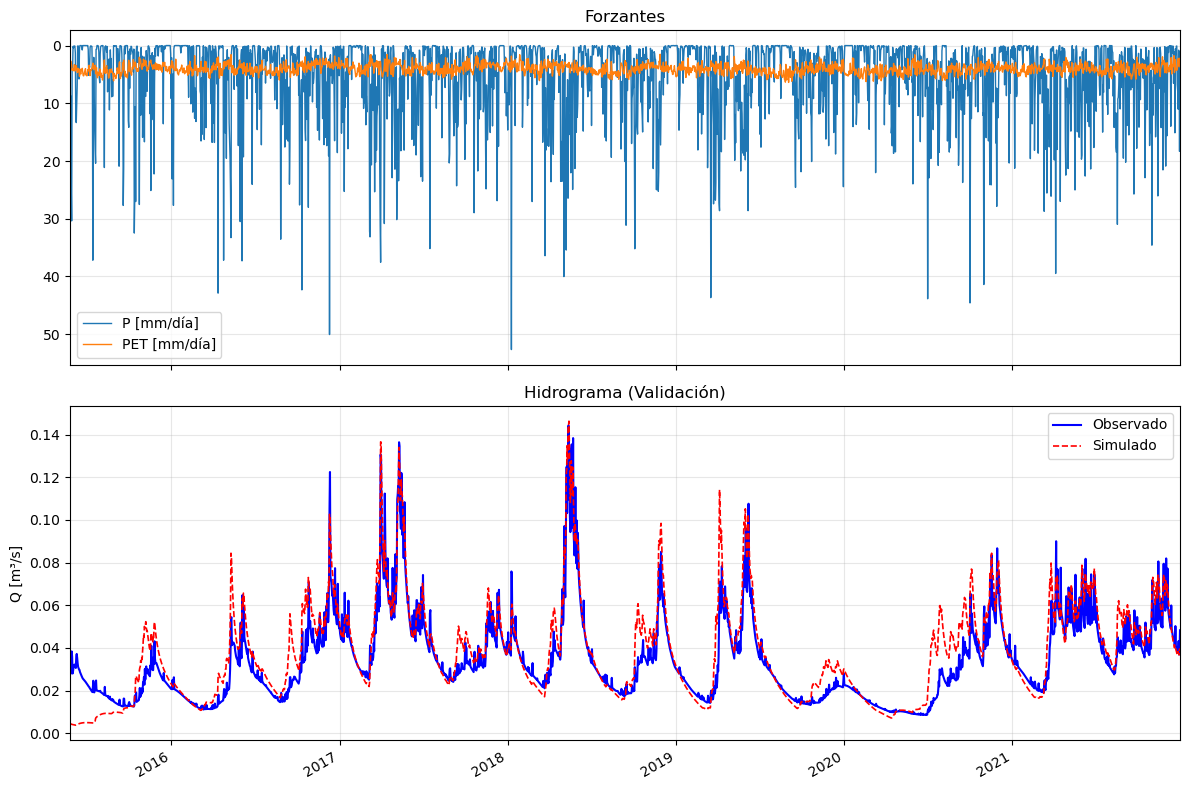

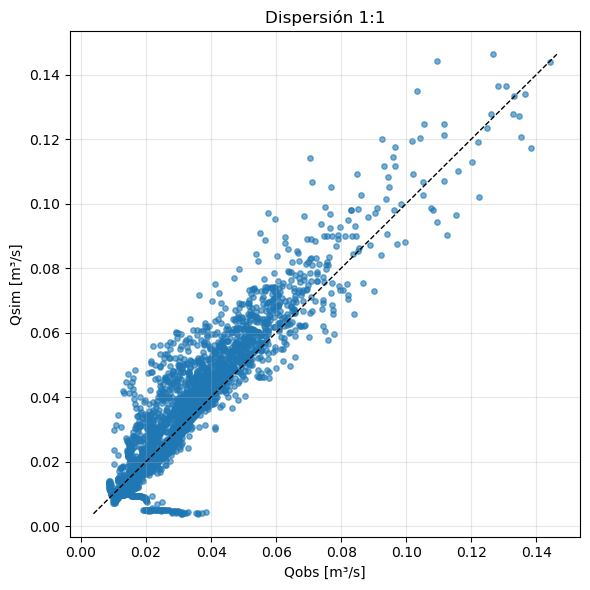

In [40]:

    # 7) Gráficos
    plot_results(val_df['date'].values, qobs_val, qsim_val,
                 precip=precip_val, etp=etp_val,
                 title_suffix="(Validación)")